In [630]:
import struct
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 


In [565]:
metadataImpact = pd.read_csv("golf-swing-dataset/data/golfDB.csv", sep=",", usecols=["id", "youtube_id", "sex", "club", "slow", "kf7"])
metadataImpact = metadataImpact.rename(columns={"kf7" : "impactFrame", "youtube_id" : "youtubeId"})
metadataImpact.slow = metadataImpact.slow.apply(lambda x: True if x == 1 else x).apply(lambda x: False if x == 0 else x)
metadataImpact = metadataImpact[metadataImpact["slow"] == False].drop("slow", axis=1)
metadataImpact.head()

,id,youtubeId,sex,club,impactFrame
0,0,f1BWA5F87Jc,f,driver,498
2,2,tA1iotgtMyc,m,driver,698
4,4,wDCKLePrwHA,f,driver,205
6,6,iPuVhnI8pJU,m,driver,332
8,8,-M5SITXMA2Y,f,driver,355


In [566]:
basePath = "/Users/metinozturk/Downloads/AI/"

<h1>Num Of Channels, Sample Rate, Bit Depth</h1>

<h2>Impact Sounds</h2>

In [567]:
audioImpactdata = []
for index, row in metadataImpact.iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"
    if not os.path.exists(fileName):
        continue       
    readImpactProperties = readFileProperties(fileName)
    audioImpactdata.append(readProperties)

# Convert into a Panda dataframe
audioImpactDf = pd.DataFrame(audioImpactdata, columns=['num_channels','sample_rate','bit_depth'])

In [568]:
audioImpactDf.head()

,num_channels,sample_rate,bit_depth
0,2,44100,16
1,2,44100,16
2,2,44100,16
3,2,44100,16
4,2,44100,16


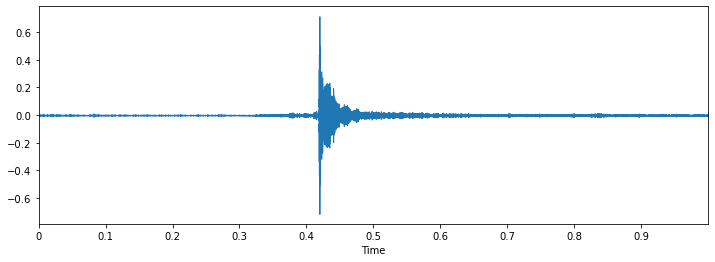

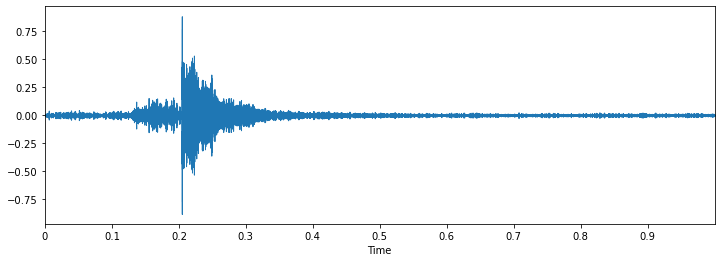

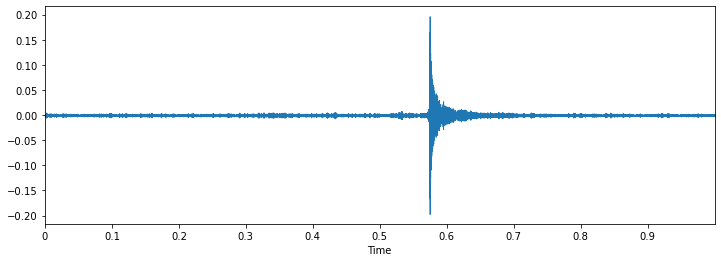

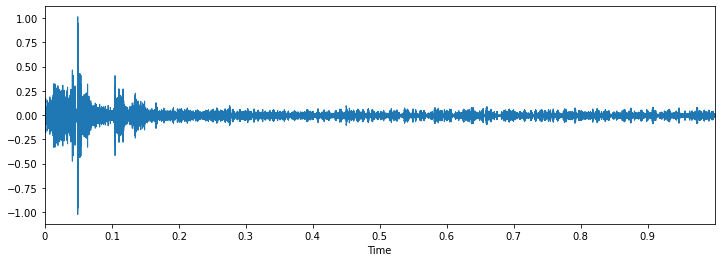

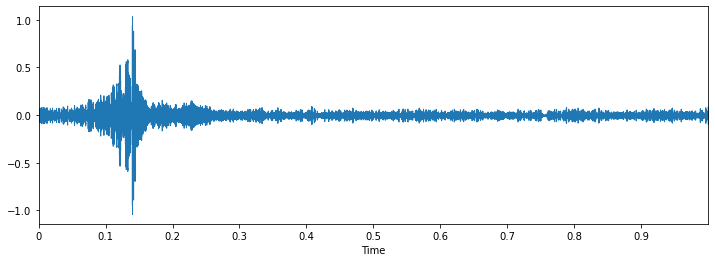

In [569]:
for index, row in metadataImpact.head().iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"

    plt.figure(figsize=(12,4))
    retrievedData ,sample_rate = librosa.load(fileName)
    _ = librosa.display.waveplot(retrievedData,sr=sample_rate)

<h2>Control Sounds</h2>

In [576]:
metadata = pd.read_csv(f'{basePath}UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [577]:
audioControldata = []
for index, row in metadata.iterrows():
    fileName = f"/Users/metinozturk/Downloads/AI/controlAudios/{row['slice_file_name']}"
    tempData = readFileProperties(fileName)
    audioControldata.append(tempData)

# Convert into a Panda dataframe
audioControldf = pd.DataFrame(audioControldata, columns=['num_channels','sample_rate','bit_depth'])
audioControldf = audioControldf[(audioControldf["sample_rate"] == 44100) & (audioControldf["bit_depth"] == 16) & (audioControldf["num_channels"] == 2)]

In [578]:
metadata = metadata.loc[audioControldf.index, :].reset_index()

# metadata = metadata.loc[0:len(data), :]

<h1> Model Training </h1>

<h3> Multilayer Perceptron </h3>

In [518]:
features = []
for index, row in metadataImpact.iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"
    if not os.path.exists(fileName):
        continue       
    class_label = "impact"
    readImpactFeatures = extract_features(fileName)
    features.append([readImpactFeatures, class_label])
    
for index,row in metadata.iterrows():
    fileName = f"{basePath}UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"
    if not os.path.exists(fileName):
        continue     
    class_label = "control"
    readControlFeatures = extract_features(fileName)
    features.append([readControlFeatures, class_label])
    
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
#Shuffle
featuresdf = featuresdf.sample(frac = 1)

In [519]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [520]:
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [521]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary 
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_33 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_34 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)               

In [522]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
accuracy

13.894523680210114

In [523]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=f'{basePath}savedModels/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

model.save(f"{basePath}savedModels/lvsAudioRecognitionModel.hdf5")

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 94/124 [=====================>........] - ETA: 0s - loss: 5.9943 - accuracy: 0.7576
Epoch 00001: val_loss improved from inf to 0.32053, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 2ms/step - loss: 5.1638 - accuracy: 0.7644 - val_loss: 0.3205 - val_accuracy: 0.8986
Epoch 2/100
108/124 [=========================>....] - ETA: 0s - loss: 1.3492 - accuracy: 0.8168
Epoch 00002: val_loss improved from 0.32053 to 0.25533, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 1.2913 - accuracy: 0.8154 - val_loss: 0.2553 - val_accuracy: 0.9199
Epoch 3/100
 89/124 [====================>.........] - ETA: 0s - loss: 0.5827 - accuracy: 0.8409
Epoch 00003: val_loss did not improve from 0.25533
124/124 [==============================] - 0s 1ms/step - loss: 0.5874 - accuracy: 0.8362 - val_loss: 0.2907 - va

Epoch 25/100
115/124 [==========================>...] - ETA: 0s - loss: 0.1025 - accuracy: 0.9609
Epoch 00025: val_loss did not improve from 0.08141
124/124 [==============================] - 0s 1ms/step - loss: 0.1013 - accuracy: 0.9612 - val_loss: 0.0852 - val_accuracy: 0.9665
Epoch 26/100
 95/124 [=====================>........] - ETA: 0s - loss: 0.1001 - accuracy: 0.9572
Epoch 00026: val_loss improved from 0.08141 to 0.07831, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9594 - val_loss: 0.0783 - val_accuracy: 0.9746
Epoch 27/100
107/124 [========================>.....] - ETA: 0s - loss: 0.0895 - accuracy: 0.9655
Epoch 00027: val_loss did not improve from 0.07831
124/124 [==============================] - 0s 1ms/step - loss: 0.0826 - accuracy: 0.9688 - val_loss: 0.0880 - val_accuracy: 0.9635
Epoch 28/100
 81/124 [==================>...........] - ETA: 0s - l

Epoch 53/100
109/124 [=========================>....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9819
Epoch 00053: val_loss did not improve from 0.06542
124/124 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.9815 - val_loss: 0.0685 - val_accuracy: 0.9726
Epoch 54/100
115/124 [==========================>...] - ETA: 0s - loss: 0.0582 - accuracy: 0.9788
Epoch 00054: val_loss improved from 0.06542 to 0.06286, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 0.9792 - val_loss: 0.0629 - val_accuracy: 0.9746
Epoch 55/100
104/124 [========================>.....] - ETA: 0s - loss: 0.0575 - accuracy: 0.9781
Epoch 00055: val_loss did not improve from 0.06286
124/124 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 0.9790 - val_loss: 0.0820 - val_accuracy: 0.9736
Epoch 56/100
118/124 [===========================>..] - ETA: 0s - l

Epoch 82/100
114/124 [==========================>...] - ETA: 0s - loss: 0.0395 - accuracy: 0.9871
Epoch 00082: val_loss did not improve from 0.05655
124/124 [==============================] - 0s 1ms/step - loss: 0.0416 - accuracy: 0.9861 - val_loss: 0.0733 - val_accuracy: 0.9767
Epoch 83/100
118/124 [===========================>..] - ETA: 0s - loss: 0.0481 - accuracy: 0.9849
Epoch 00083: val_loss did not improve from 0.05655
124/124 [==============================] - 0s 1ms/step - loss: 0.0486 - accuracy: 0.9840 - val_loss: 0.0643 - val_accuracy: 0.9807
Epoch 84/100
113/124 [==========================>...] - ETA: 0s - loss: 0.0518 - accuracy: 0.9806
Epoch 00084: val_loss did not improve from 0.05655
124/124 [==============================] - 0s 1ms/step - loss: 0.0513 - accuracy: 0.9810 - val_loss: 0.0647 - val_accuracy: 0.9807
Epoch 85/100
120/124 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9849
Epoch 00085: val_loss did not improve from 0.05655
124/124 [==

In [524]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.996703028678894
Testing Accuracy:  0.9807302355766296


<h3>CNN</h3>

In [622]:
features = []
for index, row in metadataImpact.iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"
    if not os.path.exists(fileName):
        continue       
    class_label = "impact"
    readImpactFeatures = extractFeaturesForCNN(fileName)
    features.append([readImpactFeatures, class_label])
    
for index,row in metadata.iterrows():
    fileName = f"/Users/metinozturk/Downloads/AI/controlAudios/{row['slice_file_name']}"
    if not os.path.exists(fileName):
        continue     
    class_label = "control"
    readControlFeatures = extractFeaturesForCNN(fileName)
    features.append([readControlFeatures, class_label])
    
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
featuresdf = featuresdf.sample(frac = 1)

In [623]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 41)

In [624]:
num_rows = 40
num_columns = 87
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [625]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [626]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 39, 86, 16)        80        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 19, 43, 16)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 19, 43, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 18, 42, 32)        2080      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 9, 21, 32)         0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 9, 21, 32)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 8, 20, 64)       

In [627]:
num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath=f'{basePath}savedModels/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

model.save(f"{basePath}savedModels/lvsAudioRecognitionModel.hdf5")

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
18/18 [==============================] - ETA: 0s - loss: 5.6157 - accuracy: 0.8015
Epoch 00001: val_loss improved from inf to 0.76071, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
18/18 [==============================] - 3s 140ms/step - loss: 5.6157 - accuracy: 0.8015 - val_loss: 0.7607 - val_accuracy: 0.6766
Epoch 2/72
18/18 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.8070
Epoch 00002: val_loss improved from 0.76071 to 0.33760, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
18/18 [==============================] - 2s 134ms/step - loss: 0.7929 - accuracy: 0.8070 - val_loss: 0.3376 - val_accuracy: 0.8584
Epoch 3/72
18/18 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.8424
Epoch 00003: val_loss improved from 0.33760 to 0.32357, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
18/18 [=====================

18/18 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9534
Epoch 00026: val_loss improved from 0.13688 to 0.13624, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
18/18 [==============================] - 3s 143ms/step - loss: 0.1223 - accuracy: 0.9534 - val_loss: 0.1362 - val_accuracy: 0.9580
Epoch 27/72
18/18 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9578
Epoch 00027: val_loss improved from 0.13624 to 0.12852, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
18/18 [==============================] - 3s 147ms/step - loss: 0.1132 - accuracy: 0.9578 - val_loss: 0.1285 - val_accuracy: 0.9624
Epoch 28/72
18/18 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9583
Epoch 00028: val_loss did not improve from 0.12852
18/18 [==============================] - 2s 136ms/step - loss: 0.1123 - accuracy: 0.9583 - val_loss: 0.1296 - val_accuracy: 0.

Epoch 52/72
18/18 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9845
Epoch 00052: val_loss did not improve from 0.05824
18/18 [==============================] - 2s 136ms/step - loss: 0.0458 - accuracy: 0.9845 - val_loss: 0.0656 - val_accuracy: 0.9816
Epoch 53/72
18/18 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9889
Epoch 00053: val_loss did not improve from 0.05824
18/18 [==============================] - 3s 140ms/step - loss: 0.0445 - accuracy: 0.9889 - val_loss: 0.0642 - val_accuracy: 0.9834
Epoch 54/72
18/18 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9856
Epoch 00054: val_loss did not improve from 0.05824
18/18 [==============================] - 2s 136ms/step - loss: 0.0412 - accuracy: 0.9856 - val_loss: 0.0694 - val_accuracy: 0.9834
Epoch 55/72
18/18 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9875
Epoch 00055: val_loss improved from 0.05824 to 0.05519, saving model to /U

In [628]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9940983653068542
Testing Accuracy:  0.9851398468017578


In [629]:
kerasFile = tf.keras.models.load_model(f"{basePath}savedModels/lvsAudioRecognitionModel.hdf5") 
# converter=tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
converter=tf.lite.TFLiteConverter.from_keras_model(kerasFile)
converter.experimental_new_converter = True
tfmodel = converter.convert()
open(f"{basePath}savedModels/lvsSoundRecognitionModel.tflite","wb").write(tfmodel)


INFO:tensorflow:Assets written to: /var/folders/hg/zkkc1xx51ss9fc83m03jpj9h0000gn/T/tmppeqgwl_6/assets


INFO:tensorflow:Assets written to: /var/folders/hg/zkkc1xx51ss9fc83m03jpj9h0000gn/T/tmppeqgwl_6/assets


178424

In [609]:
idx = 12
fileName = f"{basePath}audios/{metadataImpact.iloc[idx].id + 1}-{metadataImpact.iloc[idx].youtubeId}.wav"
print_prediction(fileName)

The predicted class is: impact 

control :  0.00010500515782041475176811218262
impact :  0.99989497661590576171875000000000


In [617]:
idx = 32
fileName = f"/Users/metinozturk/Downloads/AI/controlAudios/{metadata.loc[idx]['slice_file_name']}"
print_prediction(fileName)

The predicted class is: control 

control :  0.99954754114151000976562500000000
impact :  0.00045244715875014662742614746094


In [618]:
filename = f"{basePath}deneme.wav"
print_prediction(filename)

The predicted class is: control 

control :  0.98978030681610107421875000000000
impact :  0.01021969877183437347412109375000


In [604]:
def print_prediction(file_name):
    prediction_feature = extractFeaturesForCNN(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    # predicted_vector = model.predict_classes(prediction_feature)
    predicted_vector = np.argmax(model.predict(prediction_feature), axis=-1)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], ": ", format(predicted_proba[i], '.32f') )

In [620]:
max_pad_len = 87
def extractFeaturesForCNN(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', sr=44100, mono=True)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512, n_mels = 128)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print("Error encountered while parsing file: ", file_name," Error: ", e)
        return None 
     
    return mfccs

<h1>Functions:</h1>

In [538]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', sr=44100, mono=True) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512, n_mels = 128)
        mfccsscaled = np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [394]:
def readFileProperties(filename):
    
    wave_file = open(filename,"rb")

    riff = wave_file.read(12)
    fmt = wave_file.read(36)

    num_channels_string = fmt[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]

    sample_rate_string = fmt[12:16]
    sample_rate = struct.unpack("<I",sample_rate_string)[0]

    bit_depth_string = fmt[22:24]
    bit_depth = struct.unpack("<H",bit_depth_string)[0]

    return (num_channels, sample_rate, bit_depth)